**DUAL ATTENTION BASED RNN :**

Google Drive Mount :



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
cd drive/My\ Drive

/content/drive/My Drive


In [0]:
# Importation des packages
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from pytorchtools import *
import matplotlib.pyplot as plt

from torch.autograd import Variable

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

Le modèle :



In [0]:
class Encoder(nn.Module):
    """encoder in DA_RNN."""

    def __init__(self, T,
                 input_size,
                 encoder_num_hidden,
                 parallel=False):
        """Initialize an encoder in DA_RNN."""
        super(Encoder, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.input_size = input_size
        self.parallel = parallel
        self.T = T

        # Fig 1. Temporal Attention Mechanism: Encoder is LSTM
        self.encoder_lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.encoder_num_hidden,
            num_layers = 1
        )

        # Construct Input Attention Mechanism via deterministic attention model
        # Eq. 8: W_e[h_{t-1}; s_{t-1}] + U_e * x^k
        self.encoder_attn = nn.Linear(
            in_features=2 * self.encoder_num_hidden + self.T - 1,
            out_features=1
        )

    def forward(self, X):
        """forward.

        Args:
            X: input data

        """
        X_tilde = Variable(X.data.new(
            X.size(0), self.T - 1, self.input_size).zero_())
        X_encoded = Variable(X.data.new(
            X.size(0), self.T - 1, self.encoder_num_hidden).zero_())

        # Eq. 8, parameters not in nn.Linear but to be learnt
        # v_e = torch.nn.Parameter(data=torch.empty(
        #     self.input_size, self.T).uniform_(0, 1), requires_grad=True)
        # U_e = torch.nn.Parameter(data=torch.empty(
        #     self.T, self.T).uniform_(0, 1), requires_grad=True)
        # h_n, s_n: initial states with dimention hidden_size
        h_n = self._init_states(X)
        s_n = self._init_states(X)

        for t in range(self.T - 1):
            # batch_size * input_size * (2 * hidden_size + T - 1)
            x = torch.cat((h_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           s_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           X.permute(0, 2, 1)), dim=2)

            x = self.encoder_attn(
                x.view(-1, self.encoder_num_hidden * 2 + self.T - 1))

            # get weights by softmax
            alpha = F.softmax(x.view(-1, self.input_size))

            # get new input for LSTM
            x_tilde = torch.mul(alpha, X[:, t, :])

            # Fix the warning about non-contiguous memory
            # https://discuss.pytorch.org/t/dataparallel-issue-with-flatten-parameter/8282
            self.encoder_lstm.flatten_parameters()

            # encoder LSTM
            _, final_state = self.encoder_lstm(x_tilde.unsqueeze(0), (h_n, s_n))
            h_n = final_state[0]
            s_n = final_state[1]

            X_tilde[:, t, :] = x_tilde
            X_encoded[:, t, :] = h_n

        return X_tilde, X_encoded

    def _init_states(self, X):
        """Initialize all 0 hidden states and cell states for encoder.

        Args:
            X

        Returns:
            initial_hidden_states
        """
        # https://pytorch.org/docs/master/nn.html?#lstm
        return Variable(X.data.new(1, X.size(0), self.encoder_num_hidden).zero_())


class Decoder(nn.Module):
    """decoder in DA_RNN."""

    def __init__(self, T, decoder_num_hidden, encoder_num_hidden):
        """Initialize a decoder in DA_RNN."""
        super(Decoder, self).__init__()
        self.decoder_num_hidden = decoder_num_hidden
        self.encoder_num_hidden = encoder_num_hidden
        self.T = T

        self.attn_layer = nn.Sequential(
            nn.Linear(2 * decoder_num_hidden + encoder_num_hidden, encoder_num_hidden),
            nn.Tanh(),
            nn.Linear(encoder_num_hidden, 1)
        )
        self.lstm_layer = nn.LSTM(
            input_size=1,
            hidden_size=decoder_num_hidden
        )
        self.fc = nn.Linear(encoder_num_hidden + 1, 1)
        self.fc_final = nn.Linear(decoder_num_hidden + encoder_num_hidden, 1)

        self.fc.weight.data.normal_()

    def forward(self, X_encoded, y_prev):
        """forward."""
        d_n = self._init_states(X_encoded)
        c_n = self._init_states(X_encoded)

        for t in range(self.T - 1):

            x = torch.cat((d_n.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           c_n.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           X_encoded), dim=2)

            beta = F.softmax(self.attn_layer(
                x.view(-1, 2 * self.decoder_num_hidden + self.encoder_num_hidden)).view(-1, self.T - 1))

            # Eqn. 14: compute context vector
            # batch_size * encoder_hidden_size
            context = torch.bmm(beta.unsqueeze(1), X_encoded)[:, 0, :]
            if t < self.T - 1:
                # Eqn. 15
                # batch_size * 1
                y_tilde = self.fc(
                    torch.cat((context, y_prev[:, t].unsqueeze(1)), dim=1))

                # Eqn. 16: LSTM
                self.lstm_layer.flatten_parameters()
                _, final_states = self.lstm_layer(
                    y_tilde.unsqueeze(0), (d_n, c_n))

                d_n = final_states[0]  # 1 * batch_size * decoder_num_hidden
                c_n = final_states[1]  # 1 * batch_size * decoder_num_hidden

        # Eqn. 22: final output
        y_pred = self.fc_final(torch.cat((d_n[0], context), dim=1))

        return y_pred

    def _init_states(self, X):
        """Initialize all 0 hidden states and cell states for encoder.

        Args:
            X
        Returns:
            initial_hidden_states

        """
        # hidden state and cell state [num_layers*num_directions, batch_size, hidden_size]
        # https://pytorch.org/docs/master/nn.html?#lstm
        return Variable(X.data.new(1, X.size(0), self.decoder_num_hidden).zero_())


class DA_rnn(nn.Module):
    """da_rnn."""

    def __init__(self, X, y, T,
                 encoder_num_hidden,
                 decoder_num_hidden,
                 batch_size,
                 learning_rate,
                 epochs,
                 parallel=False):
        """da_rnn initialization."""
        super(DA_rnn, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.decoder_num_hidden = decoder_num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.parallel = parallel
        self.shuffle = False
        self.epochs = epochs
        self.T = T
        self.X = X
        self.y = y

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print("==> Use accelerator: ", self.device)

        self.Encoder = Encoder(input_size=X.shape[1],
                               encoder_num_hidden=encoder_num_hidden,
                               T=T).to(self.device)
        self.Decoder = Decoder(encoder_num_hidden=encoder_num_hidden,
                               decoder_num_hidden=decoder_num_hidden,
                               T=T).to(self.device)

        # Loss function
        self.criterion = nn.MSELoss()

        if self.parallel:
            self.encoder = nn.DataParallel(self.encoder)
            self.decoder = nn.DataParallel(self.decoder)

        self.encoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.Encoder.parameters()),
                                            lr=self.learning_rate)
        self.decoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.Decoder.parameters()),
                                            lr=self.learning_rate)

        # Training set
        self.train_timesteps = int(self.X.shape[0] * 0.7)
        print("Nb de données en Train",self.train_timesteps)
        self.y = (self.y - np.mean(self.y[:self.train_timesteps])) 
        self.input_size = self.X.shape[1]

        # Validation set 
        self.valid_timesteps = int(self.X.shape[0] * 0.1)
        print("Nb de données en Valid",self.valid_timesteps)
        print("Nb de données en Test",self.X.shape[0]-self.valid_timesteps-self.train_timesteps)

    def train(self):
        """training process."""
        early_stopping = EarlyStopping(patience=2, verbose=True)
        iter_per_epoch = int(np.ceil(self.train_timesteps * 1. / self.batch_size))
        self.iter_losses = np.zeros(self.epochs * iter_per_epoch)
        self.epoch_losses = np.zeros(self.epochs)

        iter_per_epoch_valid= int(np.ceil(self.valid_timesteps * 1. / self.batch_size))
        self.iter_losses_valid = np.ones(self.epochs * iter_per_epoch_valid) * float("inf")
        self.epoch_losses_valid= np.zeros(self.epochs)

        n_iter = 0

        for epoch in range(self.epochs):
            if self.shuffle:
                ref_idx = np.random.permutation(self.train_timesteps - self.T)
            else:
                ref_idx = np.array(range(self.train_timesteps - self.T))
                ref_idx_valid=  np.array(range(self.train_timesteps - self.T,self.train_timesteps+self.valid_timesteps - self.T +1 ))
            idx = 0
            idx_valid=0

            while (idx < self.train_timesteps):
                # get the indices of X_train]
                indices = ref_idx[idx:(idx + self.batch_size)]
                #print(idx,"Train")
                #print(ref_idx.shape,"Train_shape")
                # x = np.zeros((self.T - 1, len(indices), self.input_size))
                x = np.zeros((len(indices), self.T - 1, self.input_size))
                y_prev = np.zeros((len(indices), self.T - 1))
                y_gt = self.y[indices + self.T]

                # format x into 3D tensor
                for bs in range(len(indices)):
                    x[bs, :, :] = self.X[indices[bs]:(indices[bs] + self.T - 1), :]
                    y_prev[bs, :] = self.y[indices[bs]: (indices[bs] + self.T - 1)]

                loss = self.train_forward(x, y_prev, y_gt)
                self.iter_losses[int(epoch * iter_per_epoch + idx / self.batch_size)] = loss

                idx += self.batch_size
                n_iter += 1
                if n_iter % 10000 == 0 and n_iter != 0:
                    for param_group in self.encoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                    for param_group in self.decoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9

                self.epoch_losses[epoch] = np.mean(self.iter_losses[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
                
            while idx_valid < self.valid_timesteps :
              indices_valid = ref_idx_valid[idx_valid:(idx_valid + self.batch_size)]
              #print(idx_valid,"Valid")
              #print(ref_idx_valid.shape,"Valid_shape")
              x = np.zeros((len(indices_valid), self.T - 1, self.input_size))
              y_prev = np.zeros((len(indices_valid), self.T - 1))
              y_gt = self.y[indices_valid + self.T]

              # format x into 3D tensor
              for bs in range(len(indices_valid)):
                  x[bs, :, :] = self.X[indices_valid[bs]:(indices_valid[bs] + self.T - 1), :]
                  y_prev[bs, :] = self.y[indices_valid[bs]: (indices_valid[bs] + self.T - 1)]

              loss_valid = self.train_forward(x, y_prev, y_gt,back=False)
              self.iter_losses_valid[int(epoch * iter_per_epoch_valid + idx_valid / self.batch_size)] = loss_valid

              idx_valid += self.batch_size
              self.epoch_losses_valid[epoch] = np.mean(self.iter_losses_valid[range(
                    epoch * iter_per_epoch_valid, (epoch + 1) * iter_per_epoch_valid)])
              

            early_stopping( self.epoch_losses_valid[epoch], self)
            if epoch % 10 == 0:
                print("Epochs: ", epoch, " Iterations: ", n_iter,
                      " Loss_train: ", self.epoch_losses[epoch])
                print("Epochs: ", epoch, " Iterations: ", n_iter,
                      " Loss_valid: ",  self.epoch_losses_valid[epoch])
              



    def train_forward(self, X, y_prev, y_gt,back=True):
        """
        Forward pass.

        Args:
            X:
            y_prev:
            y_gt: Ground truth label

        """
        # zero gradients
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        input_weighted, input_encoded = self.Encoder(
            Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
        y_pred = self.Decoder(input_encoded, Variable(
            torch.from_numpy(y_prev).type(torch.FloatTensor).to(self.device)))

        y_true = Variable(torch.from_numpy(
            y_gt).type(torch.FloatTensor).to(self.device))

        y_true = y_true.view(-1, 1)
        loss = self.criterion(y_pred, y_true)
        if back :
          loss.backward()
          self.encoder_optimizer.step()
          self.decoder_optimizer.step()

        return loss.item()


    def test(self, on_train=False):
        """test."""

        if on_train:
            y_pred = np.zeros(self.train_timesteps - self.T + 1)
        else:
            y_pred = np.zeros(self.X.shape[0] - (self.train_timesteps + self.valid_timesteps))

        i = 0
        while i < len(y_pred):
            batch_idx = np.array(range(len(y_pred)))[i: (i + self.batch_size)]
            X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
            y_history = np.zeros((len(batch_idx), self.T - 1))

            for j in range(len(batch_idx)):
                if on_train:
                    X[j, :, :] = self.X[range(
                        batch_idx[j], batch_idx[j] + self.T - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j], batch_idx[j] + self.T - 1)]
                else:
                    X[j, :, :] = self.X[range(
                        batch_idx[j] + self.train_timesteps + self.valid_timesteps - self.T, batch_idx[j] + self.train_timesteps + self.valid_timesteps - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j] + self.train_timesteps + self.valid_timesteps - self.T, batch_idx[j] + self.train_timesteps + self.valid_timesteps - 1)]

            y_history = Variable(torch.from_numpy(
                y_history).type(torch.FloatTensor).to(self.device))
            _, input_encoded = self.Encoder(
                Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
            y_pred[i:(i + self.batch_size)] = self.Decoder(input_encoded,
                                                           y_history).cpu().data.numpy()[:, 0]
            i += self.batch_size

        return y_pred

    

Lecture des données NASDAQ :

In [0]:
def read_data(input_path, debug=True):
    """Read nasdaq stocks data.

    Args:
        input_path (str): directory to nasdaq dataset.

    Returns:
        X (np.ndarray): features.
        y (np.ndarray): ground truth.

    """
    df = pd.read_csv(input_path)
    # X = df.iloc[:, 0:-1].values
    X = df.loc[:, [x for x in df.columns.tolist() if x != 'NDX']].as_matrix()
    # y = df.iloc[:, -1].values
    y = np.array(df.NDX)
    if debug :
      b=[i*10 for i in range(int(X.shape[0]/10)) ]
      X=X[b][:3600]
      y=y[b][:3600]

    return X, y


Train et predict sur les données du NASDAQ :

In [9]:
dataroot = 'nasdaq100_padding.csv'

batchsize = 128
nhidden_encoder = 128
nhidden_decoder = 128
ntimestep = 10
lr = 0.001
epochs = 150




# Read dataset
print("==> Load dataset ...")
X, y = read_data(dataroot, debug=False)


# Initialize model
print("==> Initialize DA-RNN model ...")
model = DA_rnn(
    X,
    y,
    ntimestep,
    nhidden_encoder,
    nhidden_decoder,
    batchsize,
    lr,
    epochs
)

# Train
print("==> Start training ...")
model.train()

# Prediction
model.load_state_dict(torch.load('checkpoint.pt'))
y_pred = model.test()


==> Load dataset ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


==> Initialize DA-RNN model ...
==> Use accelerator:  cuda:0
Nb de données en Train 28392
Nb de données en Valid 4056
Nb de données en Test 8112
==> Start training ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: ignored

Résultats :

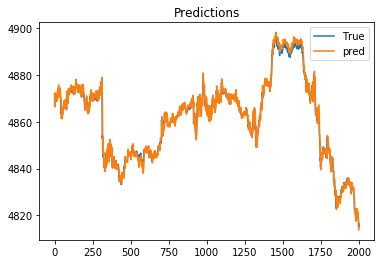

MSE en test : 3.660477936884998
ecart-type 1.893229885412349


In [0]:
plt.plot(y[model.train_timesteps+model.valid_timesteps:][:2000], label="True")
plt.plot(y_pred[:2000]  + np.mean(y[:model.train_timesteps]),label="pred")
plt.title("Predictions")
plt.legend()
plt.show()
print("MSE en test :", mean_squared_error(y[model.train_timesteps+model.valid_timesteps:][:2000], y_pred[:2000] + np.mean(y[:model.train_timesteps])))
print("ecart-type",np.std(np.abs(y[model.train_timesteps+model.valid_timesteps:][:2000]-y_pred[:2000] + np.mean(y[:model.train_timesteps]))))

Comparaison avec un modèle qui dit y(t-1) pour y(t) :

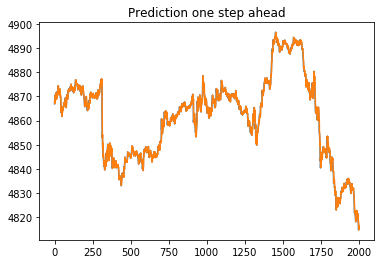

MSE en test : 1.3799495552777008
ecart-type 0.8872749127446964


In [0]:
x_t = y[model.train_timesteps+model.valid_timesteps:][:2000]
y_t=np.roll(x_t, 1)[:2000]
plt.plot(x_t[1:])
plt.plot(y_t[1:])
plt.title("Prediction one step ahead")
plt.show()
print("MSE en test :",mean_squared_error(x_t[1:], y_t[1:]))
print("ecart-type",np.std(np.abs(x_t[1:]-y_t[1:])))

Loss :

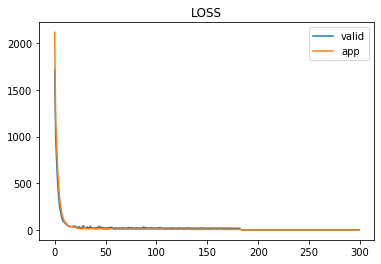

In [0]:
plt.plot(model.epoch_losses_valid,label="valid")
plt.plot(model.epoch_losses,label="app")
plt.title("LOSS")
plt.legend()
plt.show()

Avec les données du NASDAQ bruitées :

In [0]:
X_b=np.zeros(X.shape)
for i in range (X.shape[1]) :
  X_b[:,i]= X[:,i] + np.random.normal(0,i+1,size=X[:,i].shape)
print(X_b)

[[  35.98         96.65808344   93.86576042 ...  -30.52222862
   -31.80804668   25.55466548]
 [  35.931        96.01463274  100.0314081  ...  -73.11724695
   -90.95496565   32.82362087]
 [  35.9044       96.97622763   95.62028474 ... -117.37218195
   103.26118709  132.30683011]
 ...
 [  48.53        113.6482232   104.38400536 ...   41.34064922
     0.15138458    6.772336  ]
 [  48.56        115.74766919  104.11259956 ...   88.82060352
    22.37436913   16.8148002 ]
 [  48.56        115.71620759  102.12973646 ...   -6.76575454
    30.70768234   -9.76684177]]


In [0]:
# Initialize model
print("==> Initialize DA-RNN model ...")
model = DA_rnn(
    X_b,
    y,
    ntimestep,
    nhidden_encoder,
    nhidden_decoder,
    batchsize,
    lr,
    epochs
)

# Train
print("==> Start training ...")
model.train()

# Prediction
model.load_state_dict(torch.load('checkpoint.pt'))
y_pred = model.test()


==> Initialize DA-RNN model ...
==> Use accelerator:  cuda:0
Nb de données en Train 28392
Nb de données en Valid 4056
Nb de données en Test 8112
==> Start training ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation loss decreased (inf --> 2191.603249).  Saving model ...
Epochs:  0  Iterations:  222  Loss_train:  2572.311758138038
Epochs:  0  Iterations:  222  Loss_valid:  2191.603249132633
Validation loss decreased (2191.603249 --> 1082.665627).  Saving model ...
Validation loss decreased (1082.665627 --> 380.655840).  Saving model ...
Validation loss decreased (380.655840 --> 145.961603).  Saving model ...
Validation loss decreased (145.961603 --> 80.934675).  Saving model ...
Validation loss decreased (80.934675 --> 56.083455).  Saving model ...
Validation loss decreased (56.083455 --> 45.338343).  Saving model ...
Validation loss decreased (45.338343 --> 36.581982).  Saving model ...
Validation loss decreased (36.581982 --> 27.279258).  Saving model ...
Epochs:  10  Iterations:  2442  Loss_train:  20.10237748934342
Epochs:  10  Iterations:  2442  Loss_valid:  56.785651698708534
Epochs:  20  Iterations:  4662  Loss_train:  26.484703807680457
Epochs:  20  Iterations:  4662  Loss_valid

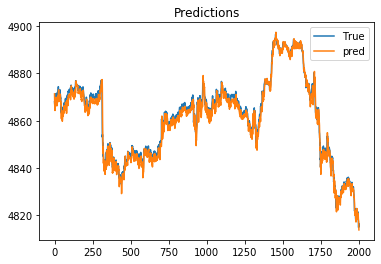

MSE en test : 5.576037078072961
ecart-type 1.9254504958554903


In [0]:
plt.plot(y[model.train_timesteps+model.valid_timesteps:][:2000], label="True")
plt.plot(y_pred[:2000]  + np.mean(y[:model.train_timesteps]),label="pred")
plt.title("Predictions")
plt.legend()
plt.show()
print("MSE en test :", mean_squared_error(y[model.train_timesteps+model.valid_timesteps:][:2000], y_pred[:2000] + np.mean(y[:model.train_timesteps])))
print("ecart-type",np.std(np.abs(y[model.train_timesteps+model.valid_timesteps:][:2000]-y_pred[:2000] + np.mean(y[:model.train_timesteps]))))

Avec un timestep plus grand (on prends un point tout les 10 points):


In [22]:
# Read dataset
print("==> Load dataset ...")
X, y = read_data(dataroot, debug=True)


# Initialize model
print("==> Initialize DA-RNN model ...")
model = DA_rnn(
    X,
    y,
    ntimestep,
    nhidden_encoder,
    nhidden_decoder,
    batchsize,
    lr,
    epochs
)

# Train
print("==> Start training ...")
model.train()

# Prediction
model.load_state_dict(torch.load('checkpoint.pt'))
y_pred = model.test()

==> Load dataset ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


==> Initialize DA-RNN model ...
==> Use accelerator:  cuda:0
Nb de données en Train 2520
Nb de données en Valid 360
Nb de données en Test 720
==> Start training ...
Validation loss decreased (inf --> 4765.302327).  Saving model ...
Epochs:  0  Iterations:  20  Loss_train:  2740.646106147766
Epochs:  0  Iterations:  20  Loss_valid:  4765.302327473958
Validation loss decreased (4765.302327 --> 4594.378784).  Saving model ...
Validation loss decreased (4594.378784 --> 4396.799683).  Saving model ...
Validation loss decreased (4396.799683 --> 4101.695475).  Saving model ...
Validation loss decreased (4101.695475 --> 3903.890218).  Saving model ...
Validation loss decreased (3903.890218 --> 3720.246053).  Saving model ...
Validation loss decreased (3720.246053 --> 3451.689209).  Saving model ...
Validation loss decreased (3451.689209 --> 3015.249552).  Saving model ...
Validation loss decreased (3015.249552 --> 2939.175720).  Saving model ...
Validation loss decreased (2939.175720 --> 2809.

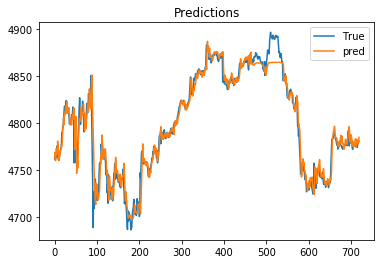

MSE en test : 145.54385377720925
ecart-type 12.064094172806907


In [23]:
plt.plot(y[model.train_timesteps+model.valid_timesteps:], label="True")
plt.plot(y_pred  + np.mean(y[:model.train_timesteps]),label="pred")
plt.title("Predictions ")
plt.legend()
plt.show()
print("MSE en test :", mean_squared_error(y[model.train_timesteps+model.valid_timesteps:], y_pred + np.mean(y[:model.train_timesteps])))
print("ecart-type",np.std(np.abs(y[model.train_timesteps+model.valid_timesteps:]-y_pred + np.mean(y[:model.train_timesteps]))))

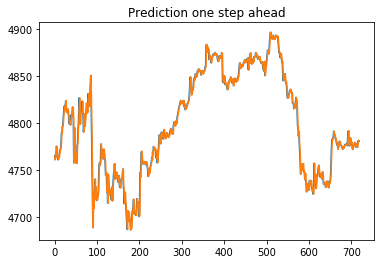

MSE en test : 53.43702527677403
ecart-type 5.668992680982279


In [24]:
x_t = y[model.train_timesteps+model.valid_timesteps:]
y_t=np.roll(x_t, 1)
plt.plot(x_t[1:])
plt.plot(y_t[1:])
plt.title("Prediction one step ahead")
plt.show()
print("MSE en test :",mean_squared_error(x_t[1:], y_t[1:]))
print("ecart-type",np.std(np.abs(x_t[1:]-y_t[1:])))

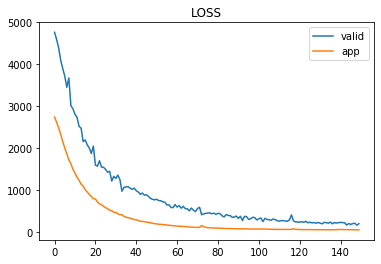

In [25]:
plt.plot(model.epoch_losses_valid,label="valid")
plt.plot(model.epoch_losses,label="app")
plt.title("LOSS")
plt.legend()
plt.show()

Avec les données du CAC 40 :

In [0]:
def read_stock_yahoo(rootpath,path_list):
  #Selectione seulement la colone voulue
  df1=pd.read_csv(rootpath+'/'+path_list[0])
  df1=df1[["Date","Close"]]
  for path in path_list[1:] :
    df2=pd.read_csv(rootpath+'/'+path)
    join=pd.merge(df1,df2[["Date","Close"]],on=["Date"])
    df1=join.copy()
  #Mets les bons noms aux bonnes colones
  for i in range(0,len(path_list)):
    col_name='Close_'+path_list[i][:-4] 
    df1.rename(columns={ df1.columns[i+1] : col_name }, inplace = True)

  return df1

In [0]:
rootpath="RNN_CAC/CAC40-Data/"
path_list=['AIR.PA.csv','ORA.PA.csv','ENGI.PA.csv','HO.PA.csv',
           'MC.PA.csv','VIV.PA.csv','SAN.PA.csv','FP.PA.csv',
           'FTI.PA.csv','OR.PA.csv','VIE.PA.csv','RI.PA.csv','FCHI.csv']
df=read_stock_yahoo(rootpath,path_list)
df.head()

X = np.array(df.iloc[:, 1:-1].values)
y = np.array(df.iloc[:, -1].values)
s = pd.DataFrame(X)
X=np.array(s.interpolate(method='linear', limit_direction='forward', axis=0))

batchsize = 30
nhidden_encoder = 128
nhidden_decoder = 128
ntimestep = 10
lr = 0.001
epochs = 100

In [0]:
# Initialize model
print("==> Initialize DA-RNN model ...")
model = DA_rnn(
    X,
    y,
    ntimestep,
    nhidden_encoder,
    nhidden_decoder,
    batchsize,
    lr,
    epochs
)

# Train
print("==> Start training ...")
model.train()

# Prediction
model.load_state_dict(torch.load('checkpoint.pt'))
y_pred = model.test()

==> Initialize DA-RNN model ...
==> Use accelerator:  cuda:0
Nb de données en Train 893
Nb de données en Valid 127
Nb de données en Test 257
==> Start training ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation loss decreased (inf --> 204269.425781).  Saving model ...
Epochs:  0  Iterations:  30  Loss_train:  167766.09166666667
Epochs:  0  Iterations:  30  Loss_valid:  204269.42578125
Validation loss decreased (204269.425781 --> 202380.170508).  Saving model ...
Validation loss decreased (202380.170508 --> 199675.882031).  Saving model ...
Validation loss decreased (199675.882031 --> 196694.929883).  Saving model ...
Validation loss decreased (196694.929883 --> 192603.448047).  Saving model ...
Validation loss decreased (192603.448047 --> 186043.445898).  Saving model ...
Validation loss decreased (186043.445898 --> 179576.427344).  Saving model ...
Validation loss decreased (179576.427344 --> 174680.814746).  Saving model ...
Validation loss decreased (174680.814746 --> 171836.826953).  Saving model ...
Validation loss decreased (171836.826953 --> 165479.783984).  Saving model ...
Validation loss decreased (165479.783984 --> 161088.258984).  Saving model ...
Epochs:  10  Iteration

Prédictions :

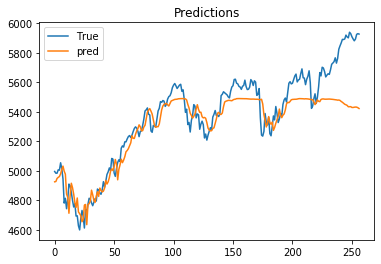

23932.53394420369

In [0]:
plt.plot(y[model.train_timesteps+model.valid_timesteps:], label="True")
plt.plot(y_pred   + np.mean(y[:model.train_timesteps]),label="pred")
plt.title("Predictions")
plt.legend()
plt.show()
print("MSE en test :" ,mean_squared_error(y[model.train_timesteps+model.valid_timesteps:], y_pred+ np.mean(y[:model.train_timesteps])))
print("ecart-type",np.std(np.abs(y[model.train_timesteps+model.valid_timesteps:]-y_pred + np.mean(y[:model.train_timesteps]))))

Modèle qui predit y(t-1) pour y(t) :

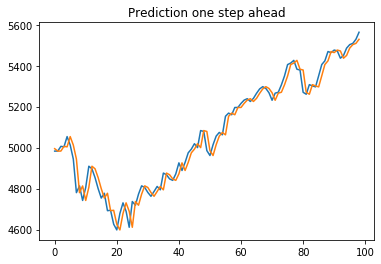

2091.942119454211

In [0]:
x_t = y[model.train_timesteps+model.valid_timesteps:]
y_t=np.roll(x_t, 1)
plt.plot(x_t[1:])
plt.plot(y_t[1:])
plt.title("Prediction one step ahead")
plt.show()
print("MSE en test de :",mean_squared_error(x_t[1:], y_t[1:]))
print("ecart-type",np.std(np.abs(x_t[1:]-y_t[1:])))

LOSS :

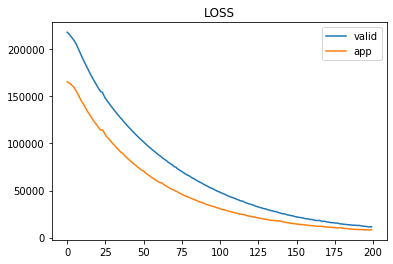

In [0]:
plt.plot(model.epoch_losses_valid,label="valid")
plt.plot(model.epoch_losses,label="app")
plt.title("LOSS")
plt.legend()
plt.show()